<a href="https://colab.research.google.com/github/arvindsuresh-math/Fall-2025-Team-Big-Data/blob/main/Naive_Recommender_System_for_NEW_AirBNB_NYC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz==1.4.1
import fastbook
fastbook.setup_book()

In [153]:
from fastbook import *
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG


In [154]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [155]:
df_rs = pd.read_parquet('/content/gdrive/MyDrive/insideairbnb/nyc/nyc_final_modeling_dataset.parquet')
display(df_rs.head(1))

,listing_id,year_month,target_price,estimated_occupancy_rate,latitude,longitude,neighbourhood_cleansed,property_type,room_type,accommodates,bedrooms,beds,bathrooms_numeric,bathrooms_type,amenities,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews_ltm,host_is_superhost,host_response_rate,host_acceptance_rate,host_identity_verified,instant_bookable,month
0,32844072,2024-10,86.0,0.266667,40.76499,-73.87989,East Elmhurst,Entire rental unit,Entire home/apt,2,2.0,1.0,1.0,private,"[""Cleaning products"", ""Private entrance"", ""Dishes and silverware"", ""Shampoo"", ""Wifi"", ""Essentials"", ""Coffee maker"", ""Outdoor furniture"", ""Heating"", ""Pets allowed"", ""Long term stays allowed"", ""Refrigerator"", ""Carbon monoxide alarm"", ""Stove"", ""Private patio or balcony"", ""Keypad"", ""Hot water"", ""Microwave"", ""City skyline view"", ""Air conditioning"", ""Baking sheet"", ""Laundromat nearby"", ""Kitchen"", ""Dryer"", ""Portable fans"", ""Cooking basics"", ""Exterior security cameras on property"", ""Conditioner"", ""Body soap"", ""Self check-in"", ""Smoke alarm"", ""Luggage dropoff allowed"", ""Bed linens"", ""32 inch HDTV""]",4.72,4.82,4.77,4.82,4.63,4.71,1,False,0.79,0.81,True,False,10


In [156]:
dep_var = 'target_price'
cont_rs, cat_rs = cont_cat_split(df_rs, max_card=9000, dep_var=dep_var)

In [157]:
df_rs[cat_rs].nunique()

,0
year_month,11
neighbourhood_cleansed,220
property_type,58
room_type,4
accommodates,16
bathrooms_type,2
amenities,78483
number_of_reviews_ltm,403
host_is_superhost,2
host_identity_verified,2


In [158]:
df_rs[cont_rs].nunique()

,0
listing_id,17222
estimated_occupancy_rate,15
latitude,14601
longitude,13951
bedrooms,13
beds,19
bathrooms_numeric,18
review_scores_rating,167
review_scores_cleanliness,171
review_scores_checkin,137


In [159]:
unique_values = df_rs['listing_id'].unique()
print(len(unique_values), len(df_rs['listing_id']))

17222 83218


In [160]:
cont_rs.remove('listing_id')
cat_rs.append('listing_id')

In [161]:
splits = RandomSplitter()(range_of(df_rs))

In [162]:
procs_rs = [Categorify, FillMissing, Normalize]
to_rs = TabularPandas(df_rs, procs_rs, cat_rs, cont_rs, y_names=dep_var, splits=splits)

In [163]:
dls = to_rs.dataloaders(bs=1024)

In [164]:
y = to_rs.train.y
y.min(),y.max()

(3.0, 50052.0)

In [165]:
learn = tabular_learner(dls, y_range=(y.min(),y.max()), layers=[500,250], n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.002511886414140463)

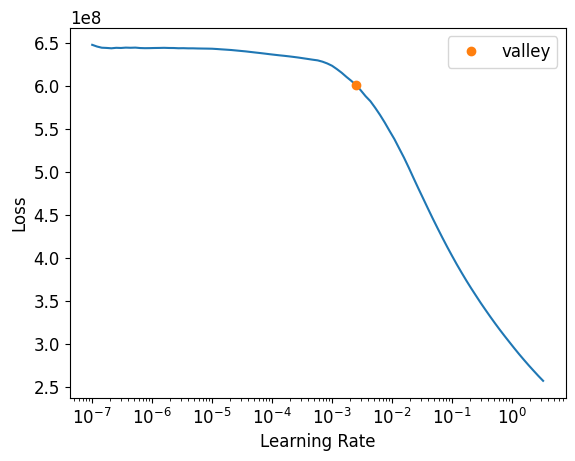

In [166]:
learn.lr_find()

In [167]:
learn.fit_one_cycle(10, 0.001)

epoch,train_loss,valid_loss,time
0,504110816.000000,454069760.000000,00:02
1,270048000.000000,103113104.000000,00:02
2,129016080.000000,38059916.000000,00:02
3,61455360.000000,17674466.000000,00:02
4,34845400.000000,6725904.000000,00:02
5,23155790.000000,5699465.500000,00:02
6,16519869.000000,6176029.000000,00:02
7,15367756.000000,5070989.000000,00:02
8,13024890.000000,5186726.500000,00:02
9,11941660.000000,4820729.000000,00:02


In [168]:
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)

In [169]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

2195.615973

In [170]:
#
#
#
#
#

In [171]:
def rf(xs, y, n_estimators=40, max_samples=10000,max_features=0.5, min_samples_leaf=5, **kwargs):
  return RandomForestRegressor(n_jobs = -1, n_estimators=n_estimators, max_samples = max_samples, max_features = max_features, min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [172]:
def m_rmse(m, xs, y):
  return r_mse(m.predict(xs), y)

In [173]:
procs_rf = [Categorify, FillMissing]

In [174]:
to_rf = TabularPandas(df_rs, procs_rf, cat_rs, cont_rs, y_names=dep_var, splits=splits)

In [175]:
len(to_rf.train), len(to_rf.valid)

(66575, 16643)

In [176]:
xs_rf, y_rf = to_rf.train.xs, to_rf.train.y
valid_xs_rf, valid_y_rf = to_rf.valid.xs, to_rf.valid.y

In [177]:
m = rf(xs_rf, y_rf)

In [178]:
m_rmse(m, xs_rf, y_rf), m_rmse(m, valid_xs_rf, valid_y_rf)

(764.527588, 735.705455)

In [179]:
preds = np.stack([t.predict(valid_xs_rf) for t in m.estimators_])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWa

In [180]:
r_mse(preds.mean(0), valid_y_rf)

735.705455

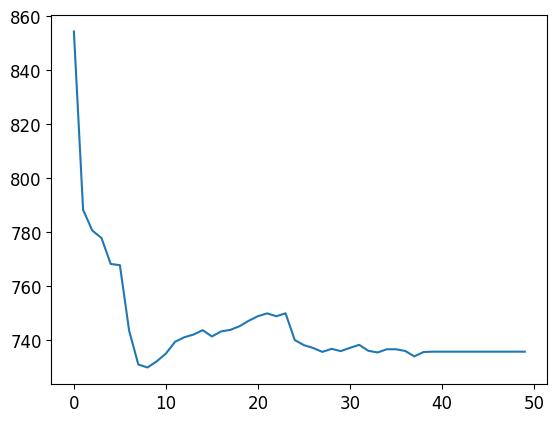

In [181]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y_rf) for i in range(50)])

In [182]:
r_mse(m.oob_prediction_, y_rf)

787.676193

In [183]:
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                      ).sort_values('imp', ascending=False)

In [184]:
fi = rf_feat_importance(m, xs_rf)
fi[:10]

,cols,imp
12,listing_id,0.148188
0,year_month,0.094813
15,longitude,0.087862
3,room_type,0.072686
6,amenities,0.068847
14,latitude,0.061423
2,property_type,0.056892
26,host_acceptance_rate,0.052578
7,number_of_reviews_ltm,0.050127
4,accommodates,0.042315


In [185]:
def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

<Axes: ylabel='cols'>

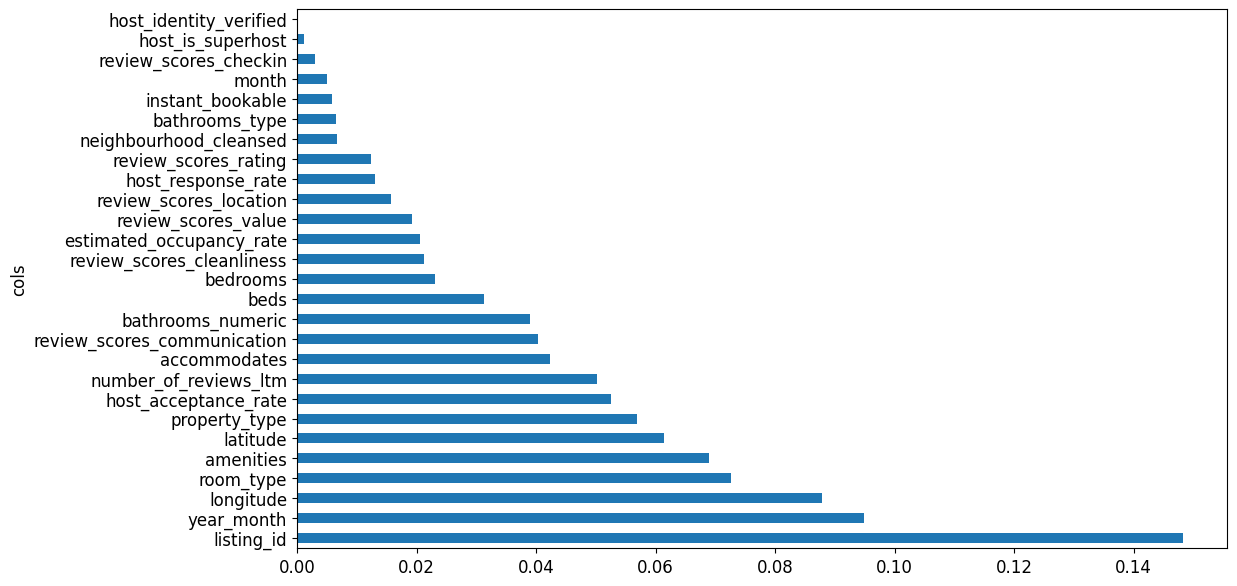

In [186]:
plot_fi(fi[:30])

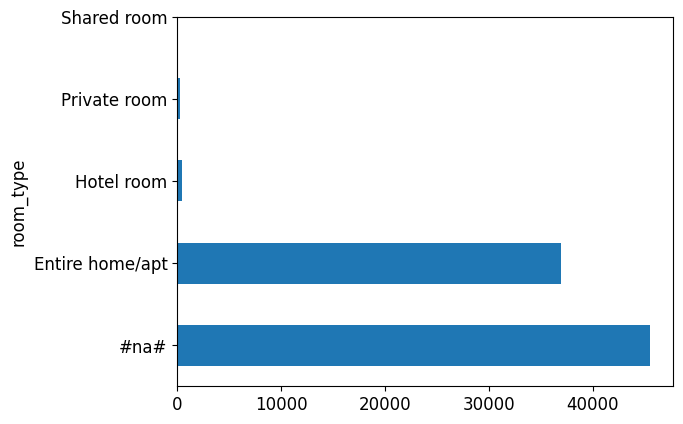

In [187]:
p = df_rs['room_type'].value_counts(sort=False).plot.barh()
c = to_rs.classes['room_type']
plt.yticks(range(len(c)), c);

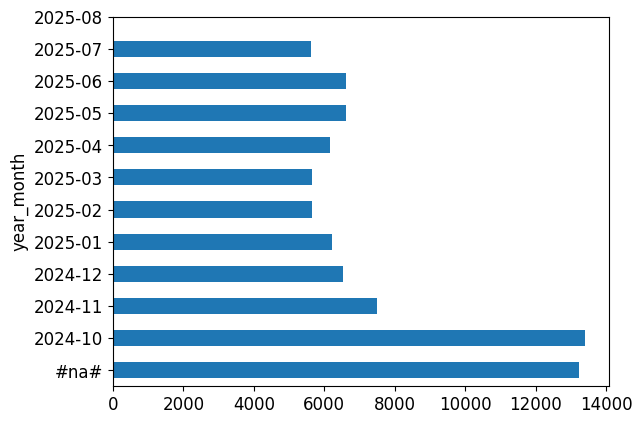

In [188]:
p = df_rs['year_month'].value_counts(sort=False).plot.barh()
c = to_rs.classes['year_month']
plt.yticks(range(len(c)), c);

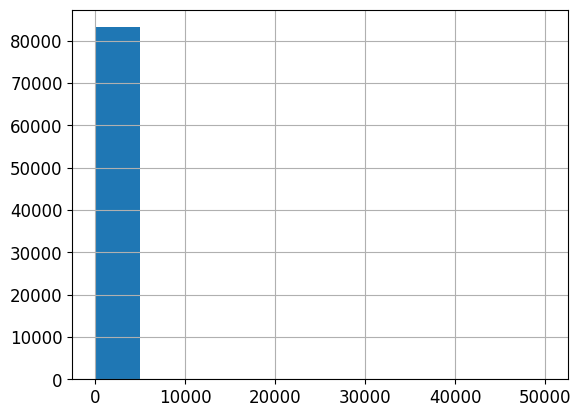

In [189]:
df_rs[dep_var].hist();

In [190]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(221, 33)
    (2): Embedding(59, 16)
    (3): Embedding(5, 4)
    (4): Embedding(17, 8)
    (5): Embedding(3, 3)
    (6): Embedding(78484, 600)
    (7): Embedding(375, 44)
    (8-10): 3 x Embedding(3, 3)
    (11): Embedding(12, 6)
    (12): Embedding(16870, 373)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=1116, out_features=500, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=500, out_features=250, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=250, out_feat

In [191]:
factor = learn.model.embeds
factor

ModuleList(
  (0): Embedding(12, 6)
  (1): Embedding(221, 33)
  (2): Embedding(59, 16)
  (3): Embedding(5, 4)
  (4): Embedding(17, 8)
  (5): Embedding(3, 3)
  (6): Embedding(78484, 600)
  (7): Embedding(375, 44)
  (8-10): 3 x Embedding(3, 3)
  (11): Embedding(12, 6)
  (12): Embedding(16870, 373)
)

In [192]:
df_rs[cat_rs].nunique()

,0
year_month,11
neighbourhood_cleansed,220
property_type,58
room_type,4
accommodates,16
bathrooms_type,2
amenities,78483
number_of_reviews_ltm,403
host_is_superhost,2
host_identity_verified,2


In [194]:
idx = dls.classes['listing_id'].o2i[np.int64(3866888)]
idx

979

In [195]:
factor[12]

Embedding(16870, 373)

In [196]:
listing_id_embeddings = learn.model.embeds[to_rs.cat_names.index('listing_id')]
listing_id_embeddings

Embedding(16870, 373)

In [197]:
distances = nn.CosineSimilarity(dim=1)(listing_id_embeddings.weight, listing_id_embeddings.weight[idx][None])

most_similar_idx = distances.argsort(descending=True)[1]
most_similar_listing_id = dls.classes['listing_id'][most_similar_idx]

most_similar_listing_id

np.int64(53477)

In [198]:
display(df_rs[df_rs['listing_id'] == np.int64(3866888)])

,listing_id,year_month,target_price,estimated_occupancy_rate,latitude,longitude,neighbourhood_cleansed,property_type,room_type,accommodates,bedrooms,beds,bathrooms_numeric,bathrooms_type,amenities,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews_ltm,host_is_superhost,host_response_rate,host_acceptance_rate,host_identity_verified,instant_bookable,month
8683,3866888,2024-10,150.0,0.133333,40.74905,-73.9831,Midtown,Entire rental unit,Entire home/apt,4,2.0,0.0,1.0,private,"[""TV"", ""Fire extinguisher"", ""Oven"", ""Dishes and silverware"", ""Wifi"", ""Patio or balcony"", ""Lockbox"", ""Heating"", ""Long term stays allowed"", ""Refrigerator"", ""Carbon monoxide alarm"", ""Stove"", ""Extra pillows and blankets"", ""Hot water"", ""Air conditioning"", ""Dedicated workspace"", ""Kitchen"", ""Cooking basics"", ""Self check-in"", ""Smoke alarm"", ""Bed linens""]",4.44,4.11,4.72,4.72,4.94,4.17,0,False,1.00,0.82,True,False,10
14076,3866888,2024-11,150.0,0.066667,40.74905,-73.9831,Midtown,Entire rental unit,Entire home/apt,4,2.0,0.0,1.0,private,"[""Fire extinguisher"", ""Smoke alarm"", ""Stove"", ""Air conditioning"", ""Extra pillows and blankets"", ""Self check-in"", ""Wifi"", ""TV"", ""Heating"", ""Dishes and silverware"", ""Long term stays allowed"", ""Carbon monoxide alarm"", ""Bed linens"", ""Dedicated workspace"", ""Hot water"", ""Refrigerator"", ""Lockbox"", ""Cooking basics"", ""Kitchen"", ""Oven"", ""Patio or balcony""]",4.44,4.11,4.72,4.72,4.94,4.17,0,True,0.94,0.84,True,False,11


In [200]:
display(df_rs[df_rs['listing_id'] == most_similar_listing_id])


,listing_id,year_month,target_price,estimated_occupancy_rate,latitude,longitude,neighbourhood_cleansed,property_type,room_type,accommodates,bedrooms,beds,bathrooms_numeric,bathrooms_type,amenities,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews_ltm,host_is_superhost,host_response_rate,host_acceptance_rate,host_identity_verified,instant_bookable,month
13064,53477,2024-10,350.0,0.200000,40.71778,-73.87714,Middle Village,Entire townhouse,Entire home/apt,12,4.0,8.0,2.0,private,"[""Air conditioning"", ""Washer"", ""Refrigerator"", ""Kitchen"", ""Dryer"", ""Free parking on premises"", ""Dishes and silverware"", ""Wifi"", ""TV with standard cable"", ""Microwave"", ""Heating"", ""Long term stays allowed""]",4.71,4.44,4.81,4.63,4.69,4.44,0,True,1.0,0.22,True,False,10
13284,53477,2024-11,350.0,0.066667,40.71778,-73.87714,Middle Village,Entire townhouse,Entire home/apt,12,4.0,8.0,2.0,private,"[""Heating"", ""TV with standard cable"", ""Washer"", ""Microwave"", ""Dishes and silverware"", ""Long term stays allowed"", ""Air conditioning"", ""Refrigerator"", ""Kitchen"", ""Wifi"", ""Free parking on premises"", ""Dryer""]",4.71,4.44,4.81,4.63,4.69,4.44,0,False,1.0,0.20,True,False,11
